In [208]:
import json

tweets_data = []
tweets_file = open('geotagged_tweets_20160812-0912.jsons', "r")
print(tweets_file)

counter = 0
for line in tweets_file:
    counter = counter + 1
    if counter > 30000:
        break
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

<_io.TextIOWrapper name='geotagged_tweets_20160812-0912.jsons' mode='r' encoding='cp1252'>


In [209]:
import os
import json
import numpy as np
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
import plotly.offline as py#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization


In [210]:
from pandas.io.json import json_normalize
# Thank gawd for this package - all json fields straight into columns in a dataframe, no bullshit
tweets_df = json_normalize(tweets_data)

tweets_df.head()

,contributors,coordinates,coordinates.coordinates,coordinates.type,created_at,entities.hashtags,entities.media,entities.symbols,entities.urls,entities.user_mentions,...,user.profile_sidebar_fill_color,user.profile_text_color,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.url,user.utc_offset,user.verified
0,None,NaN,NaN,NaN,Fri Aug 12 10:04:00 +0000 2016,[],"[{'id': 764039718237409281, 'id_str': '7640397...",[],[],"[{'screen_name': 'theblaze', 'name': 'TheBlaze...",...,EFEFEF,333333,True,False,DUPUY77,17620,None,http://ggm-dupuy.com,NaN,False
1,None,NaN,NaN,NaN,Fri Aug 12 10:04:02 +0000 2016,"[{'text': 'NOJUSTICE', 'indices': [62, 72]}, {...",NaN,[],"[{'url': 'https://t.co/5GMNZq40V3', 'expanded_...","[{'screen_name': 'BarackObama', 'name': 'Barac...",...,000000,000000,False,False,redoctapus,5046,Eastern Time (US & Canada),None,-14400.0,False
2,None,NaN,NaN,NaN,Fri Aug 12 10:04:10 +0000 2016,[],"[{'id': 764039762973896704, 'id_str': '7640397...",[],[],"[{'screen_name': 'theblaze', 'name': 'TheBlaze...",...,EFEFEF,333333,True,False,DUPUY77,17621,None,http://ggm-dupuy.com,NaN,False
3,None,NaN,NaN,NaN,Fri Aug 12 10:04:21 +0000 2016,[],NaN,[],[],"[{'screen_name': 'HillaryClinton', 'name': 'Hi...",...,99CC33,3E4415,True,False,jjorgi30,2231,Melbourne,None,36000.0,False
4,None,NaN,NaN,NaN,Fri Aug 12 10:04:30 +0000 2016,"[{'text': 'CNN', 'indices': [0, 4]}, {'text': ...",NaN,[],[],[],...,F3F3F3,333333,True,False,bspence5,92605,None,None,NaN,False


In [211]:
cols = []

for col in tweets_df.columns:
    if col in ('user.region','created_at', 'place.country','place.name','lang','text','user.name','user.location'):
        cols.append(col)

neat_df = tweets_df.loc[:, cols]
neat_df.head()

,created_at,lang,place.country,place.name,text,user.location,user.name
0,Fri Aug 12 10:04:00 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Miami,GIL DUPUY
1,Fri Aug 12 10:04:02 +0000 2016,en,United States,Baton Rouge,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"Ogletown, DE",Red Octopus
2,Fri Aug 12 10:04:10 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/n050DB...,Miami,GIL DUPUY
3,Fri Aug 12 10:04:21 +0000 2016,en,Australia,Melbourne,@HillaryClinton he will do in one year all the...,Australia,JanJorgenson
4,Fri Aug 12 10:04:30 +0000 2016,en,United States,Baltimore,#CNN #newday clear #Trump deliberately throwin...,None,Beverly Spence


In [245]:
import pandas as pd
neat_df = pd.read_parquet('file.parquet')

In [246]:
# create an empty list for the text that has been "cleaned"
list_clean_text = []

for i in neat_df["text"]:
    # this removes the hyperlink
    result = re.sub(r"http\S+", "", i)
    # this removes the people the text was directed to e.g. @HillaryClinton or @CNN
    result2 = re.sub(r"\B@\S+.", "", result)
    result3 = re.sub(r"\d+.", "", result2)
    list_clean_text.append(result3)

# make a new column with the clean text
neat_df["clean_text"] = list_clean_text
neat_df

,created_at,place.country,place.country_code,place.name,is_quote_status,lang,source,text,user.created_at,user.description,user.name,user.location,place.place_type,user.screen_name,in_reply_to_screen_name,geo.type,geo.coordinates,create_dtm,clean_text
index,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00+00:00,Fri Aug 12 10:04:00 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",GIL DUPUY,Miami,city,DUPUY77,theblaze,None,None,2016-08-12 10:04:00+00:00,
1970-01-01 00:00:00.000000001+00:00,Fri Aug 12 10:04:02 +0000 2016,United States,US,Baton Rouge,False,en,"<a href=""http://twitter.com/download/android"" ...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,Thu Oct 15 00:28:04 +0000 2009,"AWSCWI Pipefitter USAF NRA I remember USA, Hun...",Red Octopus,"Ogletown, DE",city,redoctapus,BarackObama,None,None,2016-08-12 10:04:02+00:00,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...
1970-01-01 00:00:00.000000002+00:00,Fri Aug 12 10:04:10 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/n050DB...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",GIL DUPUY,Miami,city,DUPUY77,theblaze,None,None,2016-08-12 10:04:10+00:00,
1970-01-01 00:00:00.000000003+00:00,Fri Aug 12 10:04:21 +0000 2016,Australia,AU,Melbourne,False,en,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryClinton he will do in one year all the...,Tue Jun 02 01:59:59 +0000 2009,The best movies are written and directed by pe...,JanJorgenson,Australia,city,jjorgi30,HillaryClinton,None,None,2016-08-12 10:04:21+00:00,he will do in one year all the things you shou...
1970-01-01 00:00:00.000000004+00:00,Fri Aug 12 10:04:30 +0000 2016,United States,US,Baltimore,False,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#CNN #newday clear #Trump deliberately throwin...,Mon Aug 20 09:43:48 +0000 2012,"Retired, political wonk mother of one grandmot...",Beverly Spence,None,city,bspence5,None,None,None,2016-08-12 10:04:30+00:00,#CNN #newday clear #Trump deliberately throwin...
1970-01-01 00:00:00.000000005+00:00,Fri Aug 12 10:04:46 +0000 2016,United States,US,Palm Springs,True,en,"<a href=""http://twitter.com/download/iphone"" r...","@realDonaldTrump, you wouldn't recognize a lie...",Tue May 19 03:18:19 +0000 2009,"I am a retired psychologist in Palm Springs, C...","Asa DeMatteo, Ph.D.","Palm Springs, CA",city,AsaDeMatteo,realDonaldTrump,None,None,2016-08-12 10:04:46+00:00,you wouldn't recognize a lie if it came from y...
1970-01-01 00:00:00.000000006+00:00,Fri Aug 12 10:04:47 +0000 2016,United Kingdom,GB,Hammersmith,True,und,"<a href=""http://twitter.com/#!/download/ipad"" ...",#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,Wed Nov 21 17:21:00 +0000 2012,None,Hank Moody,Stuck in the middle with you,city,JehrysTargaryen,None,None,None,2016-08-12 10:04:47+00:00,#Trump#TrumpPence#MakeAmericaGreatAgain
1970-01-01 00:00:00.000000007+00:00,Fri Aug 12 10:04:48 +0000 2016,United States,US,Secaucus,False,en,"<a href=""http://twitter.com/download/iphone"" r...","""Kid, you know, suing someone? Thats the most ...",Sun Aug 07 00:57:29 +0000 2016,Actor/Buddhist/Eccentric/Improv Comic/Libertar...,Rafael Alejandro,"Secaucus, NJ",city,GinebraFilms,None,None,None,2016-08-12 10:04:48+00:00,"""Kid, you know, suing someone? Thats the most ..."
1970-01-01 00:00:00.000000008+00:00,Fri Aug 12 10:04:48 +0000 2016,United States,US,Irving,False,en,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryClinton you ARE the co-founder of ISIS...,Wed Oct 28 18:34:22 +0000 2009,None,tom b,"Irving, TX",city,VNDISABLEDVET,HillaryClinton,None,None,2016-08-12 10:04:48+00:00,"you ARE the co-founder of ISIS, you crooked, e..."


In [247]:
#Lexicon Normalization
#performing stemming and Lemmatization
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Create a set of stopwords
stop = set(stopwords.words('english'))
stop.update(set(["n", "u", "im"]))

# Create a set of punctuation words 
exclude = set(string.punctuation) 

# This is the function makeing the lemmatization
lemma = WordNetLemmatizer()

# In this function we perform the entire cleaning
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# This is the clean corpus.
doc_clean = [clean(doc) for doc in list_clean_text] 

In [248]:
from nltk.tokenize import RegexpTokenizer
import html.parser as HTMLParser# In Python 3.4+ import html 
import nltk

# Tokenize each clean text
tokenized_tweets = []
tokenizer = RegexpTokenizer(r'\w+')
for i in doc_clean:
    tokens = tokenizer.tokenize(i)
    tokenized_tweets.append(tokens)

neat_df["tokens"] = tokenized_tweets
# flatten the list of lists to combine all words in one list
flattened_list_of_tokens = [y for x in tokenized_tweets for y in x]
neat_df

,created_at,place.country,place.country_code,place.name,is_quote_status,lang,source,text,user.created_at,user.description,user.name,user.location,place.place_type,user.screen_name,in_reply_to_screen_name,geo.type,geo.coordinates,create_dtm,clean_text,tokens
index,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00+00:00,Fri Aug 12 10:04:00 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",GIL DUPUY,Miami,city,DUPUY77,theblaze,None,None,2016-08-12 10:04:00+00:00,,[]
1970-01-01 00:00:00.000000001+00:00,Fri Aug 12 10:04:02 +0000 2016,United States,US,Baton Rouge,False,en,"<a href=""http://twitter.com/download/android"" ...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,Thu Oct 15 00:28:04 +0000 2009,"AWSCWI Pipefitter USAF NRA I remember USA, Hun...",Red Octopus,"Ogletown, DE",city,redoctapus,BarackObama,None,None,2016-08-12 10:04:02+00:00,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]"
1970-01-01 00:00:00.000000002+00:00,Fri Aug 12 10:04:10 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/n050DB...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",GIL DUPUY,Miami,city,DUPUY77,theblaze,None,None,2016-08-12 10:04:10+00:00,,[]
1970-01-01 00:00:00.000000003+00:00,Fri Aug 12 10:04:21 +0000 2016,Australia,AU,Melbourne,False,en,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryClinton he will do in one year all the...,Tue Jun 02 01:59:59 +0000 2009,The best movies are written and directed by pe...,JanJorgenson,Australia,city,jjorgi30,HillaryClinton,None,None,2016-08-12 10:04:21+00:00,he will do in one year all the things you shou...,"[one, year, thing, done, eight]"
1970-01-01 00:00:00.000000004+00:00,Fri Aug 12 10:04:30 +0000 2016,United States,US,Baltimore,False,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#CNN #newday clear #Trump deliberately throwin...,Mon Aug 20 09:43:48 +0000 2012,"Retired, political wonk mother of one grandmot...",Beverly Spence,None,city,bspence5,None,None,None,2016-08-12 10:04:30+00:00,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro..."
1970-01-01 00:00:00.000000005+00:00,Fri Aug 12 10:04:46 +0000 2016,United States,US,Palm Springs,True,en,"<a href=""http://twitter.com/download/iphone"" r...","@realDonaldTrump, you wouldn't recognize a lie...",Tue May 19 03:18:19 +0000 2009,"I am a retired psychologist in Palm Springs, C...","Asa DeMatteo, Ph.D.","Palm Springs, CA",city,AsaDeMatteo,realDonaldTrump,None,None,2016-08-12 10:04:46+00:00,you wouldn't recognize a lie if it came from y...,"[recognize, lie, came, mouth, continually, nev..."
1970-01-01 00:00:00.000000006+00:00,Fri Aug 12 10:04:47 +0000 2016,United Kingdom,GB,Hammersmith,True,und,"<a href=""http://twitter.com/#!/download/ipad"" ...",#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,Wed Nov 21 17:21:00 +0000 2012,None,Hank Moody,Stuck in the middle with you,city,JehrysTargaryen,None,None,None,2016-08-12 10:04:47+00:00,#Trump#TrumpPence#MakeAmericaGreatAgain,[trumptrumppencemakeamericagreatagain]
1970-01-01 00:00:00.000000007+00:00,Fri Aug 12 10:04:48 +0000 2016,United States,US,Secaucus,False,en,"<a href=""http://twitter.com/download/iphone"" r...","""Kid, you know, suing someone? Thats the most ...",Sun Aug 07 00:57:29 +0000 2016,Actor/Buddhist/Eccentric/Improv Comic/Libertar...,Rafael Alejandro,"Secaucus, NJ",city,GinebraFilms,None,None,None,2016-08-12 10:04:48+00:00,"""Kid, you know, suing someone? Thats the most ...","[kid, know, suing, someone, thats, beautiful, ..."
1970-01-01 00:00:00.000000008+00:00,Fri Aug 12 10:04:48 +0000 2016,United States,US,Irving,False,en,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryCl

In [38]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [249]:
from textblob import TextBlob as tb

neat_df['sentiment'] = neat_df['tokens'].apply(lambda x: tb(" ".join(x)).sentiment[0] )
#tweets[['text','calc_sentiment']]

neat_df.head()

,created_at,place.country,place.country_code,place.name,is_quote_status,lang,source,text,user.created_at,user.description,...,user.location,place.place_type,user.screen_name,in_reply_to_screen_name,geo.type,geo.coordinates,create_dtm,clean_text,tokens,sentiment
index,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00+00:00,Fri Aug 12 10:04:00 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",...,Miami,city,DUPUY77,theblaze,None,None,2016-08-12 10:04:00+00:00,,[],0.0
1970-01-01 00:00:00.000000001+00:00,Fri Aug 12 10:04:02 +0000 2016,United States,US,Baton Rouge,False,en,"<a href=""http://twitter.com/download/android"" ...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,Thu Oct 15 00:28:04 +0000 2009,"AWSCWI Pipefitter USAF NRA I remember USA, Hun...",...,"Ogletown, DE",city,redoctapus,BarackObama,None,None,2016-08-12 10:04:02+00:00,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",0.0
1970-01-01 00:00:00.000000002+00:00,Fri Aug 12 10:04:10 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/n050DB...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",...,Miami,city,DUPUY77,theblaze,None,None,2016-08-12 10:04:10+00:00,,[],0.0
1970-01-01 00:00:00.000000003+00:00,Fri Aug 12 10:04:21 +0000 2016,Australia,AU,Melbourne,False,en,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryClinton he will do in one year all the...,Tue Jun 02 01:59:59 +0000 2009,The best movies are written and directed by pe...,...,Australia,city,jjorgi30,HillaryClinton,None,None,2016-08-12 10:04:21+00:00,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",0.0
1970-01-01 00:00:00.000000004+00:00,Fri Aug 12 10:04:30 +0000 2016,United States,US,Baltimore,False,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#CNN #newday clear #Trump deliberately throwin...,Mon Aug 20 09:43:48 +0000 2012,"Retired, political wonk mother of one grandmot...",...,None,city,bspence5,None,None,None,2016-08-12 10:04:30+00:00,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",0.1


In [250]:
import re
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

neat_df['hashtags'] = neat_df.text.apply(find_hashtags)
neat_df.head()

,created_at,place.country,place.country_code,place.name,is_quote_status,lang,source,text,user.created_at,user.description,...,place.place_type,user.screen_name,in_reply_to_screen_name,geo.type,geo.coordinates,create_dtm,clean_text,tokens,sentiment,hashtags
index,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00+00:00,Fri Aug 12 10:04:00 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",...,city,DUPUY77,theblaze,None,None,2016-08-12 10:04:00+00:00,,[],0.0,[]
1970-01-01 00:00:00.000000001+00:00,Fri Aug 12 10:04:02 +0000 2016,United States,US,Baton Rouge,False,en,"<a href=""http://twitter.com/download/android"" ...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,Thu Oct 15 00:28:04 +0000 2009,"AWSCWI Pipefitter USAF NRA I remember USA, Hun...",...,city,redoctapus,BarackObama,None,None,2016-08-12 10:04:02+00:00,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",0.0,"[#NOJUSTICE, #TrumpPence]"
1970-01-01 00:00:00.000000002+00:00,Fri Aug 12 10:04:10 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/n050DB...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",...,city,DUPUY77,theblaze,None,None,2016-08-12 10:04:10+00:00,,[],0.0,[]
1970-01-01 00:00:00.000000003+00:00,Fri Aug 12 10:04:21 +0000 2016,Australia,AU,Melbourne,False,en,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryClinton he will do in one year all the...,Tue Jun 02 01:59:59 +0000 2009,The best movies are written and directed by pe...,...,city,jjorgi30,HillaryClinton,None,None,2016-08-12 10:04:21+00:00,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",0.0,[]
1970-01-01 00:00:00.000000004+00:00,Fri Aug 12 10:04:30 +0000 2016,United States,US,Baltimore,False,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#CNN #newday clear #Trump deliberately throwin...,Mon Aug 20 09:43:48 +0000 2012,"Retired, political wonk mother of one grandmot...",...,city,bspence5,None,None,None,2016-08-12 10:04:30+00:00,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",0.1,"[#CNN, #newday, #Trump, #ISIS]"


In [251]:
STATES = ['Alabama', 'AL', 'Alaska', 'AK', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut', 'CT', \
'Delaware', 'DE', 'Florida', 'FL', 'Georgia', 'GA', 'Hawaii', 'HI', 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', \
'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', \
'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', \
'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio', 'OH', 'Oklahoma', 'OK', \
'Oregon', 'OR', 'Pennsylvania', 'PA', 'Rhode Island', 'RI', 'South Carolina', 'SC', 'South Dakota', 'SD', 'Tennessee', 'TN', \
'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virginia', 'VA', 'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY']


In [252]:
import itertools
STATE_DICT = dict(itertools.zip_longest(*[iter(STATES)] * 2, fillvalue=""))
INV_STATE_DICT = dict((v,k) for k,v in STATE_DICT.items())
INV_STATE_DICT

{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'}

In [309]:
is_in_US=[]
geo = neat_df[['user.location']]
neat_df = neat_df.fillna(" ")
for x in neat_df['user.location']:
    check = False
    for s in STATES:
        if s in x:
            is_in_US.append(STATE_DICT[s] if s in STATE_DICT else s)
            check = True
            break
    if not check:
        is_in_US.append(np.nan)

neat_df['state'] = is_in_US
neat_df.head()

,created_at,place.country,place.country_code,place.name,is_quote_status,lang,source,text,user.created_at,user.description,...,geo.coordinates,create_dtm,clean_text,tokens,sentiment,hashtags,state,#nevertrump,#neverhillary,#maga
index,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00+00:00,Fri Aug 12 10:04:00 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",...,,2016-08-12 10:04:00+00:00,,[],0.0,[],NaN,False,False,False
1970-01-01 00:00:00.000000001+00:00,Fri Aug 12 10:04:02 +0000 2016,United States,US,Baton Rouge,False,en,"<a href=""http://twitter.com/download/android"" ...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,Thu Oct 15 00:28:04 +0000 2009,"AWSCWI Pipefitter USAF NRA I remember USA, Hun...",...,,2016-08-12 10:04:02+00:00,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",0.0,"[#NOJUSTICE, #TrumpPence]",DE,False,False,False
1970-01-01 00:00:00.000000002+00:00,Fri Aug 12 10:04:10 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/n050DB...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",...,,2016-08-12 10:04:10+00:00,,[],0.0,[],NaN,False,False,False
1970-01-01 00:00:00.000000003+00:00,Fri Aug 12 10:04:21 +0000 2016,Australia,AU,Melbourne,False,en,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryClinton he will do in one year all the...,Tue Jun 02 01:59:59 +0000 2009,The best movies are written and directed by pe...,...,,2016-08-12 10:04:21+00:00,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",0.0,[],NaN,False,False,False
1970-01-01 00:00:00.000000004+00:00,Fri Aug 12 10:04:30 +0000 2016,United States,US,Baltimore,False,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#CNN #newday clear #Trump deliberately throwin...,Mon Aug 20 09:43:48 +0000 2012,"Retired, political wonk mother of one grandmot...",...,,2016-08-12 10:04:30+00:00,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",0.1,"[#CNN, #newday, #Trump, #ISIS]",NaN,False,False,False


In [310]:
neat_df['#nevertrump'] = neat_df['text'].str.contains("#nevertrump", case = False)
neat_df['#neverhillary'] = neat_df['text'].str.contains("#neverhillary", case = False)
neat_df['#maga'] = neat_df['text'].str.contains("#maga", case = False)
neat_df.head()

,created_at,place.country,place.country_code,place.name,is_quote_status,lang,source,text,user.created_at,user.description,...,geo.coordinates,create_dtm,clean_text,tokens,sentiment,hashtags,state,#nevertrump,#neverhillary,#maga
index,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00+00:00,Fri Aug 12 10:04:00 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",...,,2016-08-12 10:04:00+00:00,,[],0.0,[],NaN,False,False,False
1970-01-01 00:00:00.000000001+00:00,Fri Aug 12 10:04:02 +0000 2016,United States,US,Baton Rouge,False,en,"<a href=""http://twitter.com/download/android"" ...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,Thu Oct 15 00:28:04 +0000 2009,"AWSCWI Pipefitter USAF NRA I remember USA, Hun...",...,,2016-08-12 10:04:02+00:00,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",0.0,"[#NOJUSTICE, #TrumpPence]",DE,False,False,False
1970-01-01 00:00:00.000000002+00:00,Fri Aug 12 10:04:10 +0000 2016,United States,US,Frontenac,False,und,"<a href=""http://twitter.com/download/iphone"" r...",@theblaze @realDonaldTrump https://t.co/n050DB...,Fri Sep 02 14:54:17 +0000 2011,"Fashion photographer, love action and adventur...",...,,2016-08-12 10:04:10+00:00,,[],0.0,[],NaN,False,False,False
1970-01-01 00:00:00.000000003+00:00,Fri Aug 12 10:04:21 +0000 2016,Australia,AU,Melbourne,False,en,"<a href=""http://twitter.com/download/iphone"" r...",@HillaryClinton he will do in one year all the...,Tue Jun 02 01:59:59 +0000 2009,The best movies are written and directed by pe...,...,,2016-08-12 10:04:21+00:00,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",0.0,[],NaN,False,False,False
1970-01-01 00:00:00.000000004+00:00,Fri Aug 12 10:04:30 +0000 2016,United States,US,Baltimore,False,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#CNN #newday clear #Trump deliberately throwin...,Mon Aug 20 09:43:48 +0000 2012,"Retired, political wonk mother of one grandmot...",...,,2016-08-12 10:04:30+00:00,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",0.1,"[#CNN, #newday, #Trump, #ISIS]",NaN,False,False,False


In [313]:
never_hillary_states = neat_df.groupby('state')['#neverhillary'].sum().to_frame().reset_index()
never_hillary_states.columns = ['state', 'nr. nh tweets']

never_trump_states = neat_df.groupby('state')['#nevertrump'].sum().to_frame().reset_index()
never_trump_states.columns = ['state', 'nr. nt tweets']
never_trump_states

,state,nr. nt tweets
0,AK,1.0
1,AL,8.0
2,AR,3.0
3,AZ,27.0
4,CA,111.0
5,CO,51.0
6,CT,3.0
7,DE,2.0
8,FL,52.0
9,GA,21.0


In [314]:
never_hillary_states['Full State Name'] = never_hillary_states['state'].apply(lambda x: INV_STATE_DICT[x])
never_hillary_states['text'] = never_hillary_states['Full State Name'] + '<br>' + 'Num: ' + never_hillary_states['nr. nh tweets'].astype(str)

never_trump_states['Full State Name'] = never_trump_states['state'].apply(lambda x: INV_STATE_DICT[x])
never_trump_states['text'] = never_trump_states['Full State Name'] + '<br>' + 'Num: ' + never_trump_states['nr. nt tweets'].astype(str)
never_trump_states

,state,nr. nt tweets,Full State Name,text
0,AK,1.0,Alaska,Alaska<br>Num: 1.0
1,AL,8.0,Alabama,Alabama<br>Num: 8.0
2,AR,3.0,Arkansas,Arkansas<br>Num: 3.0
3,AZ,27.0,Arizona,Arizona<br>Num: 27.0
4,CA,111.0,California,California<br>Num: 111.0
5,CO,51.0,Colorado,Colorado<br>Num: 51.0
6,CT,3.0,Connecticut,Connecticut<br>Num: 3.0
7,DE,2.0,Delaware,Delaware<br>Num: 2.0
8,FL,52.0,Florida,Florida<br>Num: 52.0
9,GA,21.0,Georgia,Georgia<br>Num: 21.0


In [316]:
#NeverHillary
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(locations= never_hillary_states['state'], z = never_hillary_states['nr. nh tweets'].astype(float), locationmode = 'USA-states', colorscale = "Oranges", text=never_hillary_states['text'], marker_line_color='white', colorbar_title = "Nr. of never Hillary tweets"))
fig.update_layout(geo_scope='usa')
fig.show(renderer="browser")

In [319]:
#NeverTrump
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(locations= never_trump_states['state'], z = never_trump_states['nr. nt tweets'].astype(float), locationmode = 'USA-states', colorscale = "Oranges", text= never_trump_states['text'], marker_line_color='white', colorbar_title = "Nr. of never Trump tweets"))
fig.update_layout(geo_scope='usa')
fig.show(renderer="browser")

In [255]:
maga_states_df =states_df.groupby('state')['sentiment'].mean().to_frame().reset_index()

In [260]:
neat_df.groupby(['state']).groups.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [261]:
sentiment_states_df = neat_df.groupby('state')['sentiment'].mean().to_frame().reset_index()
sentiment_states_df

,state,sentiment
0,AK,0.012300
1,AL,0.027427
2,AR,0.003030
3,AZ,0.028678
4,CA,0.027325
5,CO,0.036440
6,CT,0.029428
7,DE,0.028447
8,FL,0.035149
9,GA,0.031408


In [262]:
sentiment_states_df['Full State Name'] = sentiment_states_df['state'].apply(lambda x: INV_STATE_DICT[x])
sentiment_states_df['text'] = sentiment_states_df['Full State Name'] + '<br>' + 'Num: ' + sentiment_states_df['sentiment'].astype(str)
sentiment_states_df

,state,sentiment,Full State Name,text
0,AK,0.012300,Alaska,Alaska<br>Num: 0.012299718614718614
1,AL,0.027427,Alabama,Alabama<br>Num: 0.02742725507353167
2,AR,0.003030,Arkansas,Arkansas<br>Num: 0.0030304116331603265
3,AZ,0.028678,Arizona,Arizona<br>Num: 0.028677989681187687
4,CA,0.027325,California,California<br>Num: 0.027324724168228457
5,CO,0.036440,Colorado,Colorado<br>Num: 0.03643950661119336
6,CT,0.029428,Connecticut,Connecticut<br>Num: 0.029428493813998022
7,DE,0.028447,Delaware,Delaware<br>Num: 0.028447055905695632
8,FL,0.035149,Florida,Florida<br>Num: 0.035148525384636524
9,GA,0.031408,Georgia,Georgia<br>Num: 0.031407720939813685


In [263]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(locations=sentiment_states_df['state'], z = sentiment_states_df['sentiment'].astype(float), locationmode = 'USA-states', colorscale = "Blues", text=sentiment_states_df['text'], marker_line_color='white', colorbar_title = "Sentiment score"))
fig.update_layout(geo_scope='usa')
fig.show(renderer="browser")

In [266]:
tweets_by_state = neat_df['state'].value_counts()

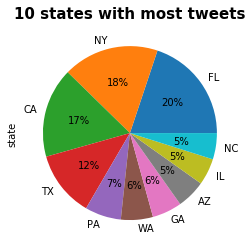

In [267]:
fig, ax = plt.subplots()
ax.set_title('10 states with most tweets', fontsize=15, fontweight='bold')
tweets_by_state[:10].plot(ax=ax, kind='pie', autopct='%1.0f%%')

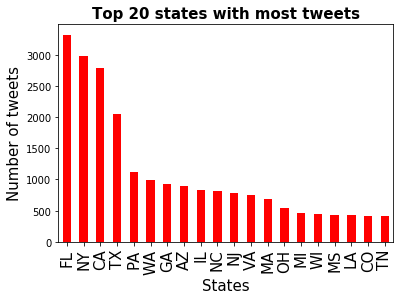

In [268]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('States', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 20 states with most tweets', fontsize=15, fontweight='bold')
tweets_by_state[:20].plot(ax=ax, kind='bar', color='red')

In [271]:
geo_dist = tweets_by_state.to_frame().reset_index()
geo_dist.columns = ['state', 'nr. of tweets']
geo_dist

,state,nr. of tweets
0,FL,3330
1,NY,2985
2,CA,2798
3,TX,2048
4,PA,1128
5,WA,997
6,GA,927
7,AZ,899
8,IL,830
9,NC,817


In [304]:
import math
geo_dist["Log Num"] = geo_dist["nr. of tweets"].apply(lambda x: math.log(x, 2))

In [273]:
geo_dist

,state,nr. of tweets,Log Num
0,FL,3330,11.701306
1,NY,2985,11.543515
2,CA,2798,11.450180
3,TX,2048,11.000000
4,PA,1128,10.139551
5,WA,997,9.961450
6,GA,927,9.856426
7,AZ,899,9.812177
8,IL,830,9.696968
9,NC,817,9.674192


In [274]:
geo_dist['Full State Name'] = geo_dist['state'].apply(lambda x: INV_STATE_DICT[x])
geo_dist['text'] = geo_dist['Full State Name'] + '<br>' + 'Num: ' + geo_dist['nr. of tweets'].astype(str)
geo_dist

,state,nr. of tweets,Log Num,Full State Name,text
0,FL,3330,11.701306,Florida,Florida<br>Num: 3330
1,NY,2985,11.543515,New York,New York<br>Num: 2985
2,CA,2798,11.450180,California,California<br>Num: 2798
3,TX,2048,11.000000,Texas,Texas<br>Num: 2048
4,PA,1128,10.139551,Pennsylvania,Pennsylvania<br>Num: 1128
5,WA,997,9.961450,Washington,Washington<br>Num: 997
6,GA,927,9.856426,Georgia,Georgia<br>Num: 927
7,AZ,899,9.812177,Arizona,Arizona<br>Num: 899
8,IL,830,9.696968,Illinois,Illinois<br>Num: 830
9,NC,817,9.674192,North Carolina,North Carolina<br>Num: 817


In [275]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(locations=geo_dist['state'], z = geo_dist['Log Num'].astype(float), locationmode = 'USA-states', colorscale = "Reds", text=geo_dist['text'], marker_line_color='white', colorbar_title = "Numbers in Log2"))
fig.update_layout(geo_scope='usa')
fig.show(renderer="browser")